This is a test loop of comparision b/w MACE and CHGNet labels using 5 data points.

In [1]:
import os
import json
import numpy as np
import pandas as pd
from ase.io import read, write
from mace.calculators import MACECalculator
from chgnet.model.model import CHGNet
from chgnet.model.dynamics import CHGNetCalculator
import torch


/home/phanim/harshitrawat/miniconda3/envs/mace_0.3.8/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_i

In [ ]:
# === Paths ===
json_path = "/home/phanim/harshitrawat/summer/temp_1/mdinfo_chgnet_predictions_forces.json"
base_cif_dir = "/home/phanim/harshitrawat/summer/md/mdcifs"
pert_cif_dir = "/home/phanim/harshitrawat/summer/md/mdcifs_strained_perturbed"
out_path = "/home/phanim/harshitrawat/summer/temp_1/mace_train_sample.extxyz"

# === Load JSON ===
with open(json_path) as f:
    data = json.load(f)

atoms_list = []

for entry in data:
    if "error" in entry:
        continue

    fname = entry["file"]
    cif_path = os.path.join(pert_cif_dir if "perturbed" in fname else base_cif_dir, fname)

    try:
        atoms = read(cif_path)
        forces = entry["forces_per_atom_eV_per_A"]
        if len(forces) != len(atoms):
            print(f"❌ force mismatch in {fname}")
            continue

        atoms.arrays["REF_forces"] = np.array(forces)
        atoms.info["REF_energy"] = entry["energy_eV"]
        atoms.info["file"] = fname  # ✅ Fix: add original filename

        atoms_list.append(atoms)
    except Exception as e:
        print(f"❌ Failed on {fname}: {e}")

# === Write EXTXYZ ===
if atoms_list:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    write(out_path, atoms_list, format="extxyz", write_info=True)
    print(f"✅ Wrote {len(atoms_list)} structures to: {out_path}")
else:
    print("⚠️ No valid structures found")


✅ Wrote 5 structures to: /home/phanim/harshitrawat/summer/temp_1/mace_train_sample.extxyz


In [ ]:
!mace_run_train \
  --name test_temp_1 \
  --model MACE \
  --train_file /home/phanim/harshitrawat/summer/temp_1/mace_train_sample.extxyz \
  --foundation_model /home/phanim/harshitrawat/summer/mace_models/universal/2024-01-07-mace-128-L2_epoch-199.model \
  --foundation_model_readout \
  --device cuda \
  --batch_size 1 \
  --valid_batch_size 1 \
  --r_max 5.0 \
  --default_dtype float64 \
  --max_num_epochs 5 \
  --forces_weight 100.0 \
  --energy_weight 1.0 \
  --valid_fraction 0.2 \
  --E0s "{3: 0.0, 8: 0.0, 40: 0.0, 57: 0.0}"

In [3]:
# === Config ===
model_path = "/home/phanim/harshitrawat/summer/test_temp_1_compiled.model"
input_extxyz = "/home/phanim/harshitrawat/summer/temp_1/mace_train_sample.extxyz"
output_jsonl = "/home/phanim/harshitrawat/summer/temp_1/mace_predictions.jsonl"
device = "cuda"

# === Load model ===
calc = MACECalculator(model_paths=model_path, device=device)

# === Predict ===
results = []

for atoms in read(input_extxyz, index=":"):
    atoms.calc = calc

    fname = atoms.info.get("file", "unknown.cif")
    fname = os.path.basename(fname)

    try:
        energy = atoms.get_potential_energy()
        forces = atoms.get_forces()

        results.append({
            "file": fname,
            "energy_eV_mace": energy,
            "forces_per_atom_eV_per_A_mace": forces.tolist(),
        })

    except Exception as e:
        results.append({
            "file": fname,
            "error": str(e),
        })

# === Save as JSONL ===
with open(output_jsonl, "w") as f:
    for entry in results:
        f.write(json.dumps(entry) + "\n")

print(f"✅ Wrote {len(results)} entries to: {output_jsonl}")


/home/phanim/harshitrawat/summer/mace/mace/calculators/mace.py:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)
/home/phanim/

Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.
✅ Wrote 5 entries to: /home/phanim/harshitrawat/summer/temp_1/mace_predictions.jsonl


In [4]:
# === Paths ===
mace_jsonl = "/home/phanim/harshitrawat/summer/temp_1/mace_predictions.jsonl"
chgnet_json = "/home/phanim/harshitrawat/summer/temp_1/mdinfo_chgnet_predictions_forces.json"

# === Load ===
mace_df = pd.read_json(mace_jsonl, lines=True)
chgnet_df = pd.read_json(chgnet_json)

# Filter only successful predictions
mace_df = mace_df[~mace_df["file"].isna()]
chgnet_df = chgnet_df[~chgnet_df["file"].isna()]

# Merge
df = mace_df.merge(chgnet_df, on="file", how="inner", suffixes=("_mace", "_chg"))

# Compare energies
df["dE_eV"] = df["energy_eV_mace"] - df["energy_eV"]

# Compare forces (L1 or L2 per-structure)
def force_mae(row):
    f1 = np.array(row["forces_per_atom_eV_per_A_mace"])
    f2 = np.array(row["forces_per_atom_eV_per_A"])
    return np.abs(f1 - f2).mean()

df["forces_mae"] = df.apply(force_mae, axis=1)

print("Energy MAE:", df["dE_eV"].abs().mean(), "eV")
print("Forces MAE:", df["forces_mae"].mean(), "eV/Å")
print(df[["file", "dE_eV", "forces_mae"]].head())


Energy MAE: 31.132116502408735 eV
Forces MAE: 0.09049007920403924 eV/Å
                                                file      dE_eV  forces_mae
0  cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla... -30.692820    0.081371
1  cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla... -30.850193    0.084471
2  cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla... -31.261529    0.091434
3  cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla... -31.502140    0.096671
4  cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_sla... -31.353900    0.098503


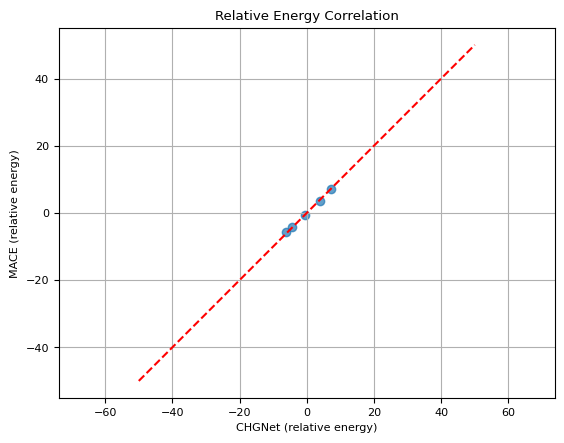

In [5]:
import matplotlib.pyplot as plt

df["rel_energy_mace"] = df["energy_eV_mace"] - df["energy_eV_mace"].mean()
df["rel_energy_chg"]  = df["energy_eV"] - df["energy_eV"].mean()

plt.scatter(df["rel_energy_chg"], df["rel_energy_mace"], alpha=0.7)
plt.xlabel("CHGNet (relative energy)")
plt.ylabel("MACE (relative energy)")
plt.title("Relative Energy Correlation")
plt.grid(True)
plt.plot([-50, 50], [-50, 50], 'r--')  # ideal line
plt.axis("equal")
plt.show()


In [6]:
offset = (df["energy_eV_mace"] - df["energy_eV"]).mean()
df["energy_eV_mace_aligned"] = df["energy_eV_mace"] - offset
df["dE_eV_aligned"] = df["energy_eV_mace_aligned"] - df["energy_eV"]

print("Aligned Energy MAE:", df["dE_eV_aligned"].abs().mean(), "eV")


Aligned Energy MAE: 0.2884879424711471 eV


In [ ]:
# pip install pymatgen mp-api
from pymatgen.ext.matproj import MPRester
from pymatgen.core.composition import Composition
from pymatgen.entries.compatibility import MaterialsProject2020Compatibility
from pymatgen.analysis.phase_diagram import PhaseDiagram

API_KEY = "j3J85pX4nLw6asHG9E2lbbCHEKDKgrjc"  # set env var MP_API_KEY instead if you prefer
ELEMENTS = ["Li", "O", "Zr", "La"]

# 1) Fetch entries in your chemistry from MP
with MPRester(API_KEY) as mpr:
    entries = mpr.get_entries_in_chemsys(ELEMENTS, inc_structure=False)

# 2) Apply MP’s official compatibility scheme (GGA/GGA+U/r2SCAN mixing etc.)
compat = MaterialsProject2020Compatibility()
proc_entries = compat.process_entries(entries)

# 3) Build a phase diagram and query MP’s per-element reference energies
pd = PhaseDiagram(proc_entries)

mp_e0s = {}
for el in ELEMENTS:
    mp_e0s[el] = float(pd.get_reference_energy_per_atom(Composition(el)))  # eV/atom

print("MP reference energies (eV/atom):", mp_e0s)
